# WhatsApp Chat Analysis

In [1]:
# Import modules and libriaries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import re 
import datetime as dt 
from urlextract import URLExtract # used to extract url's in a string
from collections import Counter
from wordcloud import WordCloud
import string 
import nltk
pd.set_option('display.max_colwidth', 100)

stopwords = nltk.corpus.stopwords.words("english")
wn = nltk.WordNetLemmatizer()
punct = string.punctuation

%matplotlib inline

## Data (text) Preprocessing

### Import Text Data

We will now import the text file which contains the whatsapp group chat in read mode using utf-8 encoding.

In [2]:
# def rawToDf(file, key):
#     split_formats = {
#         '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
#         '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
#         'custom' : ''
#     }
#     datetime_formats = {
#         '12hr' : '%m/%d/%y, %I:%M %p - ',
#         '24hr' : '%m/%d/%y, %H:%M - ',
#         'custom': ''
#     }
    
#     with open(file, 'r', encoding="utf8") as raw_data:
#         raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
#         user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
#         date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
#         df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
#     # converting date-time pattern which is of type String to type datetime,
#     # format is to be specified for the whole string where the placeholders are extracted by the method 
#     df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
#     # split user and msg 
#     usernames = []
#     msgs = []
#     for i in df['user_msg']:
#         a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
#         if(a[1:]): # user typed messages
#             usernames.append(a[1])
#             msgs.append(a[2])
#         else: # other notifications in the group(eg: someone was added, some left ...)
#             usernames.append("Group Notification")
#             msgs.append(a[0])

#     # creating new columns         
#     df['user'] = usernames
#     df['msg'] = msgs

#     # dropping the old user_msg col.
#     df.drop('user_msg', axis=1, inplace=True)
    
#     return df

In [3]:
# rawToDf("whatsapp_chat_data.txt", "24hr")

In [4]:
# import text data
f = open("whatsapp_chat_data.txt", "r", encoding="utf-8")

data = f.read()

In [5]:
dummy = data.split("\n")
dummy

['8/22/22, 19:06 - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.',
 '8/22/22, 18:40 - +254 100572102 created group "EDSA Internship Team A"',
 "8/22/22, 19:06 - You joined using this group's invite link",
 "8/22/22, 19:23 - +234 906 002 1302 joined using this group's invite link",
 "8/22/22, 19:25 - +233 27 677 7380 joined using this group's invite link",
 "8/22/22, 20:05 - +254 713 230808 joined using this group's invite link",
 "8/22/22, 20:28 - +27 72 434 6155 joined using this group's invite link",
 "8/22/22, 20:51 - +234 803 050 5798 joined using this group's invite link",
 "8/22/22, 21:05 - +234 803 791 6565 joined using this group's invite link",
 '8/23/22, 12:24 - +233 27 677 7380: okay update i have been able to complete gotten a sample submissions so i am uploading it on Kaggle to see how it goes',
 '8/23/22, 12:40 - +234 906 002 1302: Hello guys, I am about to run the EC2 instance s

### Separate messages and date/time
We want to ensure that every text entry has a date and time stamp in the specified example below:

Example for dry run : `'16/08/18, 20:09 - '`

\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s

- the first part "d{1,2}" this means here we can have one or 2 digits
- then after we have "/"
- then after we have "d{1,2}" again,same we can have one or 2 digits
- then after we have "/"
- then after we have "d{2,4}" here we check for 2 or more digits
- then a ","
- then we have a space represented as "\s"
- then we have hour representation it can take either one or 2 digits 
- then we have a seperator ":" 

and the pattern repeats so on..

In [6]:
# regex pattern to track date and time
pattern = '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s'

# Extract only the messages
messages = re.split(pattern, data)[1:]
print(len(messages))

# Extracting only the date/time
dates = re.findall(pattern, data)
print(len(dates))

1877
1877


**Sample illustration**

In [7]:
# regex pattern to track date and time
pattern = '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s'

text_data =  '8/25/22, 04:08 - Segun Lawal: Hello, please this video stopped playing at the 2:45 timestamp, only the audio was running'

In [8]:
# Extract message
re.split(pattern, text_data)[1]

'Segun Lawal: Hello, please this video stopped playing at the 2:45 timestamp, only the audio was running'

In [9]:
# Extracting only the dates
re.findall(pattern, text_data)[0]

'8/25/22, 04:08 - '

In [10]:
messages[:5]

['Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.\n',
 '+254 100572102 created group "EDSA Internship Team A"\n',
 "You joined using this group's invite link\n",
 "+234 906 002 1302 joined using this group's invite link\n",
 "+233 27 677 7380 joined using this group's invite link\n"]

In [11]:
dates[:5]

['8/22/22, 19:06 - ',
 '8/22/22, 18:40 - ',
 '8/22/22, 19:06 - ',
 '8/22/22, 19:23 - ',
 '8/22/22, 19:25 - ']

This is  a simple time string, we will apply the following transformation in order to get the date and the time for our analysis

In [12]:
string = "8/26/22, 20:09 - "
string

'8/26/22, 20:09 - '

In [13]:
string = string.split(',')
string

['8/26/22', ' 20:09 - ']

In [14]:
date,time = string[0],string[1]
date,time

('8/26/22', ' 20:09 - ')

In [15]:
time = time.split('-')
time = time[0].strip() # remove white spaces
time

'20:09'

In [16]:
print(date+ " and "+ time)

8/26/22 and 20:09


### Separate date and time
We will create a function that separates the time from the date

In [17]:
# This function separetes the time from the date
def get_date_and_time(string):
    string = string.split(",")
    date, time = string[0], string[1]
    time = time.split("-")
    time = time[0].strip()
    
    return date+" "+time 

### Create a dataframe for messages and their corresponding time

Now we have separated the messages and the time, let's create a dataframe with two columns for messages and date/time.

In [18]:
df = pd.DataFrame({"user_messages": messages, 
                   "message_date": dates})

# Apply the function that separates the time from the date
df["message_date"] = df["message_date"].apply(lambda text: get_date_and_time(text))

df.head()

,user_messages,message_date
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",8/22/22 19:06
1,"+254 100572102 created group ""EDSA Internship Team A""\n",8/22/22 18:40
2,You joined using this group's invite link\n,8/22/22 19:06
3,+234 906 002 1302 joined using this group's invite link\n,8/22/22 19:23
4,+233 27 677 7380 joined using this group's invite link\n,8/22/22 19:25


In [19]:
# Let's rename the "message_date" solumn to "date"
df.rename(columns={"message_date": "date"}, inplace=True)

df.head()

,user_messages,date
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",8/22/22 19:06
1,"+254 100572102 created group ""EDSA Internship Team A""\n",8/22/22 18:40
2,You joined using this group's invite link\n,8/22/22 19:06
3,+234 906 002 1302 joined using this group's invite link\n,8/22/22 19:23
4,+233 27 677 7380 joined using this group's invite link\n,8/22/22 19:25


In [20]:
df["user_messages"]

0       Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...
1                                                   +254 100572102 created group "EDSA Internship Team A"\n
2                                                               You joined using this group's invite link\n
3                                                 +234 906 002 1302 joined using this group's invite link\n
4                                                  +233 27 677 7380 joined using this group's invite link\n
                                                       ...                                                 
1872                                           +234 803 050 5798: You can do it nah. Is it not you again?\n
1873                                                           +234 906 002 1302: Shey you dey wyn me ni🤣\n
1874                                      +234 906 002 1302: I have no idea what half of these words mean\n
1875    +44 7903 615753: htt

### Separating users name/numbers from users message
If we observe the `user_messages` column, we find that the users name/number is attached with the user message. Therefore we need to get rid of this. For that we will use the concept of regular expression to separate the users name/number from the users message

**Sample illustration**

In [21]:
import random
txt = df["user_messages"][random.randrange(0, len(df["user_messages"]))]
txt

'Segun Lawal: ok\n'

In [22]:
re.split('([\w\W]+?):\s', txt)

['', 'Segun Lawal', 'ok\n']

In [23]:
# Separate users number/name from users message
users = []
messages = []

# loop through the "user_messages" column
for message in df["user_messages"]:
    
    # Split on the regex expression match."users name or number"
    entry = re.split('([\w\W]+?):\s', message)
    
    # very this message has a name/number
    if entry[1:]:
        users.append(entry[1])
        messages.append(entry[2])
        
    # else it is a "Group Notification"
    else:
        users.append("Group Notification")
        messages.append(entry[0])

# add the users and messages to new columns in he dataframe      
df["User"] = users
df["message"] = messages

# remove the traling "\n" and the end of each message
def get_string(text):
    return text.split("\n")[0]

df["message"] = df["message"].apply(lambda text: get_string(text))

df.head()

,user_messages,date,User,message
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",8/22/22 19:06,Group Notification,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can..."
1,"+254 100572102 created group ""EDSA Internship Team A""\n",8/22/22 18:40,Group Notification,"+254 100572102 created group ""EDSA Internship Team A"""
2,You joined using this group's invite link\n,8/22/22 19:06,Group Notification,You joined using this group's invite link
3,+234 906 002 1302 joined using this group's invite link\n,8/22/22 19:23,Group Notification,+234 906 002 1302 joined using this group's invite link
4,+233 27 677 7380 joined using this group's invite link\n,8/22/22 19:25,Group Notification,+233 27 677 7380 joined using this group's invite link


In [24]:
# Drop and rename columns
df = df.drop(columns=["user_messages"])
df = df[["message", "date", "User"]]
df = df.rename(columns={"message": "Message", 
                   "date": "Date"})
df.head()

,Message,Date,User
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",8/22/22 19:06,Group Notification
1,"+254 100572102 created group ""EDSA Internship Team A""",8/22/22 18:40,Group Notification
2,You joined using this group's invite link,8/22/22 19:06,Group Notification
3,+234 906 002 1302 joined using this group's invite link,8/22/22 19:23,Group Notification
4,+233 27 677 7380 joined using this group's invite link,8/22/22 19:25,Group Notification


In [25]:
df.head()

,Message,Date,User
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",8/22/22 19:06,Group Notification
1,"+254 100572102 created group ""EDSA Internship Team A""",8/22/22 18:40,Group Notification
2,You joined using this group's invite link,8/22/22 19:06,Group Notification
3,+234 906 002 1302 joined using this group's invite link,8/22/22 19:23,Group Notification
4,+233 27 677 7380 joined using this group's invite link,8/22/22 19:25,Group Notification


In [26]:
# get the shape of the dataframe
df.shape

(1877, 3)

### Breaking Down the "Date" Column

Our dates are in the format

`8/22/22 19:06`

Which represents:
    
`MM-DD-YY`

However, `pd.to_datetime()` will convert it to this format

`YY-MM-DD`

In [27]:
# Extract the date without time
df['Only date'] = pd.to_datetime(df['Date']).dt.date

# Get only the Year
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Get month number
df['Month_num'] = pd.to_datetime(df['Date']).dt.month

# Get name of month
df['Month'] = pd.to_datetime(df['Date']).dt.month_name()

# Get Day
df['Day'] = pd.to_datetime(df['Date']).dt.day

# Get name of Day
df['Day_name'] = pd.to_datetime(df['Date']).dt.day_name()

# Get hour
df['Hour'] = pd.to_datetime(df['Date']).dt.hour

# Get minutes
df['Minute'] = pd.to_datetime(df['Date']).dt.minute

# View dataframe head
df.head()

,Message,Date,User,Only date,Year,Month_num,Month,Day,Day_name,Hour,Minute
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",8/22/22 19:06,Group Notification,2022-08-22,2022,8,August,22,Monday,19,6
1,"+254 100572102 created group ""EDSA Internship Team A""",8/22/22 18:40,Group Notification,2022-08-22,2022,8,August,22,Monday,18,40
2,You joined using this group's invite link,8/22/22 19:06,Group Notification,2022-08-22,2022,8,August,22,Monday,19,6
3,+234 906 002 1302 joined using this group's invite link,8/22/22 19:23,Group Notification,2022-08-22,2022,8,August,22,Monday,19,23
4,+233 27 677 7380 joined using this group's invite link,8/22/22 19:25,Group Notification,2022-08-22,2022,8,August,22,Monday,19,25


We have successfully completed the `Text Preprocessing`. We will not proceed to `Text Analysis`


## Text Analysis

## Numerical Analysis

**Total number of messages in the group**

In [28]:
# Get total number of messsages in the group
len(df["Message"])

1877

**Total number of words in the group**

In [29]:
# Total number of words in the group chat
words = []
for message in df["Message"]:
    words.extend(message.split())
    
print(len(words))

13987


**Total number of media files shared in the group**

In [30]:
# Get number of media files shared in the group
len(df[df["Message"] == "<Media omitted>"])

83

**Total number of links in the group**

In [31]:
# Get number of links in the group
extract = URLExtract()

links = []
for message in df["Message"]:
    links.extend(extract.find_urls(message))
    
len(links)

71

**Most active users**

In [32]:
# discard Group notifications
active_users_df = df[df['User'] != 'Group Notification']
active_users_df.head()

,Message,Date,User,Only date,Year,Month_num,Month,Day,Day_name,Hour,Minute
9,okay update i have been able to complete gotten a sample submissions so i am uploading it on Kag...,8/23/22 12:24,+233 27 677 7380,2022-08-23,2022,8,August,23,Tuesday,12,24
10,"Hello guys, I am about to run the EC2 instance setup, if you want to do it together, and you are...",8/23/22 12:40,+234 906 002 1302,2022-08-23,2022,8,August,23,Tuesday,12,40
11,drop the meets link,8/23/22 12:40,+233 27 677 7380,2022-08-23,2022,8,August,23,Tuesday,12,40
12,Minute,8/23/22 12:41,+234 906 002 1302,2022-08-23,2022,8,August,23,Tuesday,12,41
13,https://meet.google.com/szu-kgxf-jfg?pli=1&authuser=0,8/23/22 12:44,+234 906 002 1302,2022-08-23,2022,8,August,23,Tuesday,12,44


In [33]:
# Avtive users and number of messages posted in the group
pd.DataFrame(active_users_df["User"].value_counts()).rename(columns={"User":"posts"})

,posts
+254 713 230808,444
+233 27 677 7380,364
+234 906 002 1302,264
Segun Lawal,229
+234 803 050 5798,178
+27 72 434 6155,129
+234 803 791 6565,116
+234 810 136 1613,102
+254 100572102,36
+44 7903 615753,2


In [34]:
# Top 5 active users
top_5_users = active_users_df["User"].value_counts().head()
top_5_users

+254 713 230808      444
+233 27 677 7380     364
+234 906 002 1302    264
Segun Lawal          229
+234 803 050 5798    178
Name: User, dtype: int64

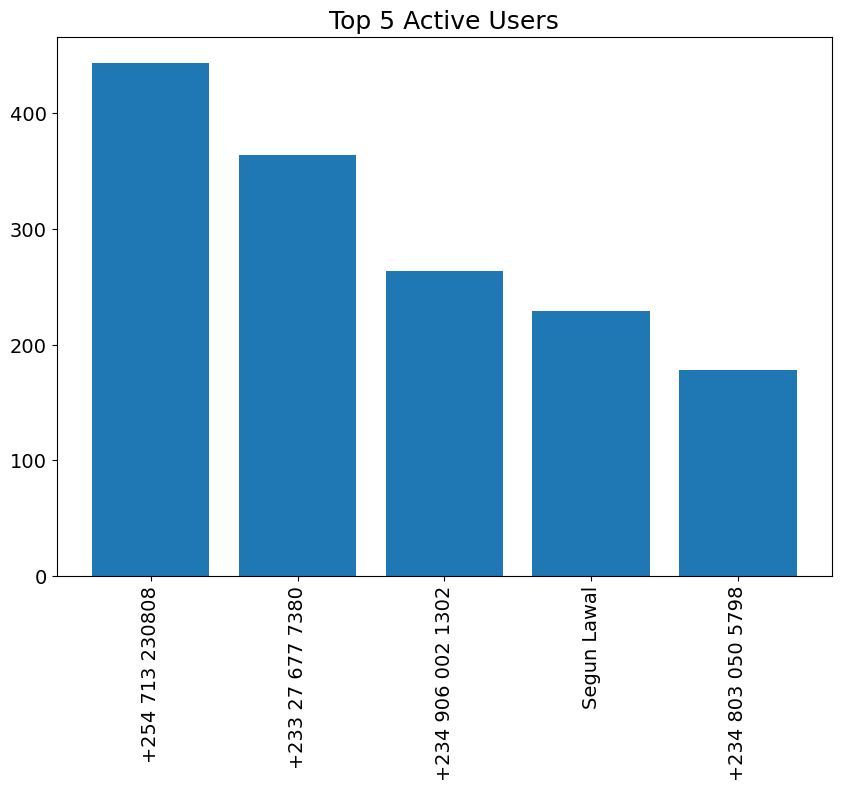

In [46]:
# Plot the bar chat of top 5 active users
plt.figure(figsize=(10, 7))
plt.bar(top_5_users.index, top_5_users.values)
plt.xticks(rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.title("Top 5 Active Users", fontsize=18);

### Word Cloud

In [36]:
# Get dataframe without "<Media omitted>"
wc_df = df[df["Message"] != "<Media omitted>"]
wc_df.head()

,Message,Date,User,Only date,Year,Month_num,Month,Day,Day_name,Hour,Minute
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",8/22/22 19:06,Group Notification,2022-08-22,2022,8,August,22,Monday,19,6
1,"+254 100572102 created group ""EDSA Internship Team A""",8/22/22 18:40,Group Notification,2022-08-22,2022,8,August,22,Monday,18,40
2,You joined using this group's invite link,8/22/22 19:06,Group Notification,2022-08-22,2022,8,August,22,Monday,19,6
3,+234 906 002 1302 joined using this group's invite link,8/22/22 19:23,Group Notification,2022-08-22,2022,8,August,22,Monday,19,23
4,+233 27 677 7380 joined using this group's invite link,8/22/22 19:25,Group Notification,2022-08-22,2022,8,August,22,Monday,19,25


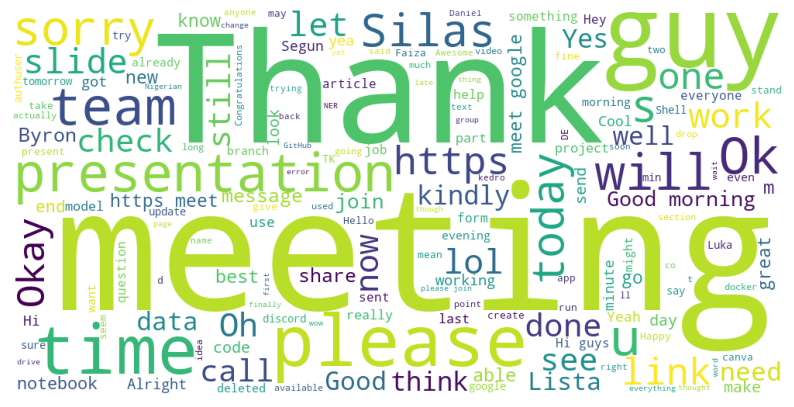

In [37]:
# create word cloud object
wc = WordCloud(width=1000, height=500, min_font_size=10, 
              background_color="white")

# generate wordcloud image
wc = wc.generate(wc_df["Message"].str.cat(sep=" "))

# plot word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wc)
plt.axis("off");

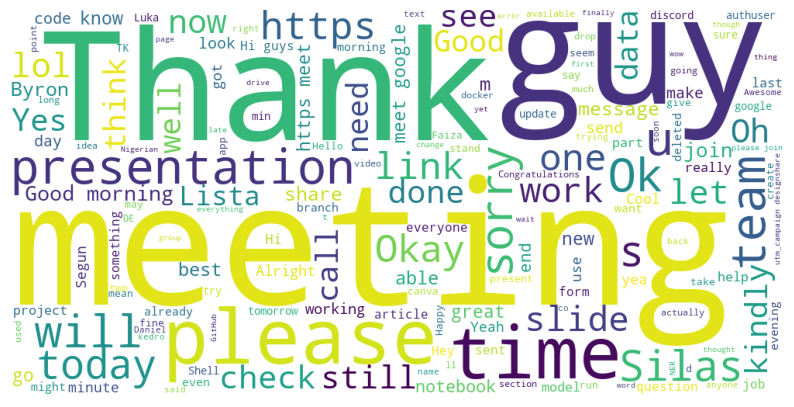

In [38]:
# create word cloud object
wc = WordCloud(width=1000, height=500, min_font_size=10, 
              background_color="white")

# generate wordcloud image
wc = wc.generate(wc_df["Message"].str.cat(sep=" "))

# plot word cloud
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(wc)
ax.axis("off");

### Most Common Words

In [39]:
# without "<Media omitted>" in meassages column
wc_df

,Message,Date,User,Only date,Year,Month_num,Month,Day,Day_name,Hour,Minute
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",8/22/22 19:06,Group Notification,2022-08-22,2022,8,August,22,Monday,19,6
1,"+254 100572102 created group ""EDSA Internship Team A""",8/22/22 18:40,Group Notification,2022-08-22,2022,8,August,22,Monday,18,40
2,You joined using this group's invite link,8/22/22 19:06,Group Notification,2022-08-22,2022,8,August,22,Monday,19,6
3,+234 906 002 1302 joined using this group's invite link,8/22/22 19:23,Group Notification,2022-08-22,2022,8,August,22,Monday,19,23
4,+233 27 677 7380 joined using this group's invite link,8/22/22 19:25,Group Notification,2022-08-22,2022,8,August,22,Monday,19,25
...,...,...,...,...,...,...,...,...,...,...,...
1872,You can do it nah. Is it not you again?,1/17/23 11:29,+234 803 050 5798,2023-01-17,2023,1,January,17,Tuesday,11,29
1873,Shey you dey wyn me ni🤣,1/17/23 16:50,+234 906 002 1302,2023-01-17,2023,1,January,17,Tuesday,16,50
1874,I have no idea what half of these words mean,1/17/23 16:51,+234 906 002 1302,2023-01-17,2023,1,January,17,Tuesday,16,51
1875,https://bupa.wd3.myworkdayjobs.com/en-US/EXT_CAREER/job/Salford-Quays/Senior-Data-Engineer_R1116984,2/7/23 17:16,+44 7903 615753,2023-02-07,2023,2,February,7,Tuesday,17,16


In [40]:
# Clean text
def clean_text(text):
    # Remove punctuations 
    text = "".join([word.lower() for word in text if word not in punct])
    
    # Remove any other signs
    text = " ".join(re.split('\W+', text))
    
    # Remove numerial leaving only aplabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    
    # Remove links and websites
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    
    text = text.split()
    
    # Remove stopwords
    text = [word for word in text if word not in stopwords]
    
    # lemmatize
    text = [wn.lemmatize(word) for word in text]
    
    #
    text = " ".join([word for word in text])
    
    return text

wc_df["clean_message"] = wc_df["Message"].apply(clean_text)
wc_df.head()

C:\Users\Segun Lawal\AppData\Local\Temp\ipykernel_13428\3095239681.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wc_df["clean_message"] = wc_df["Message"].apply(clean_text)


,Message,Date,User,Only date,Year,Month_num,Month,Day,Day_name,Hour,Minute,clean_message
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",8/22/22 19:06,Group Notification,2022-08-22,2022,8,August,22,Monday,19,6,message call endtoend encrypted one outside chat even whatsapp read listen tap learn
1,"+254 100572102 created group ""EDSA Internship Team A""",8/22/22 18:40,Group Notification,2022-08-22,2022,8,August,22,Monday,18,40,created group edsa internship team
2,You joined using this group's invite link,8/22/22 19:06,Group Notification,2022-08-22,2022,8,August,22,Monday,19,6,joined using group invite link
3,+234 906 002 1302 joined using this group's invite link,8/22/22 19:23,Group Notification,2022-08-22,2022,8,August,22,Monday,19,23,joined using group invite link
4,+233 27 677 7380 joined using this group's invite link,8/22/22 19:25,Group Notification,2022-08-22,2022,8,August,22,Monday,19,25,joined using group invite link


In [44]:
# Get top 20 words

words = []
for message in wc_df["clean_message"]:
    words.extend(message.split())

most_common = pd.DataFrame(Counter(words).most_common(20)).sort_values(1)
most_common

,0,1
19,get,39
17,morning,40
18,like,40
16,one,41
15,okay,42
14,today,44
13,silas,47
12,thank,48
11,sorry,52
10,good,54


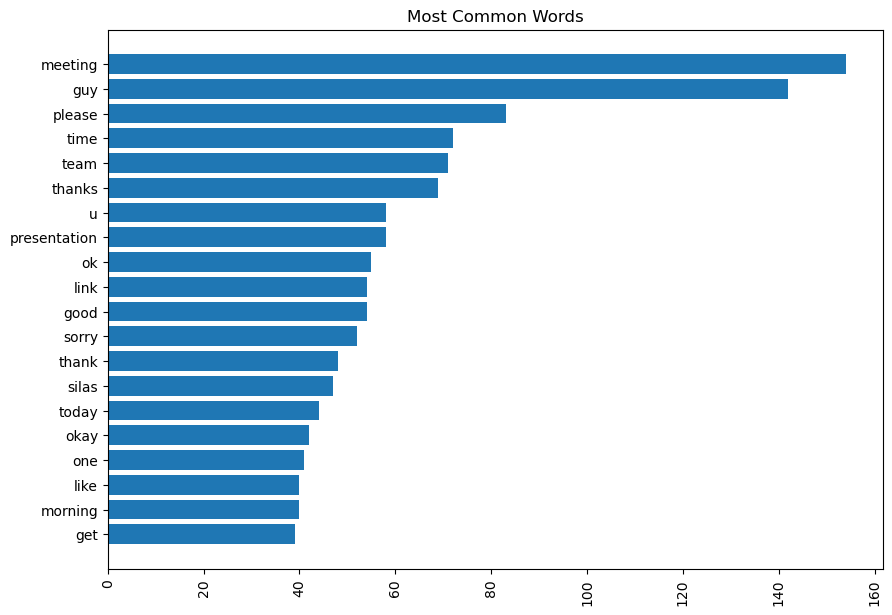

In [45]:
# Plot a graph of the most common words
plt.figure(figsize=(10, 7))
plt.barh(most_common[0], most_common[1])
plt.xticks(rotation="vertical")
plt.title("Most Common Words");